In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
import torch
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import copy
from datasets import Dataset
import pandas as pd
import torch.nn.functional as F


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
# Check if GPU is available and use it, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [4]:
import os
import random

def remove_extra_images(root_folder, max_images_per_folder=1000, random_seed=42):
    random.seed(random_seed)
    
    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)
        
        if os.path.isdir(folder_path):
            images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            random.shuffle(images)
            
            for image in images[max_images_per_folder:]:
                image_path = os.path.join(folder_path, image)
                os.remove(image_path)

root_folder = '../data/art-styles'
remove_extra_images(root_folder)


In [5]:
dataset = ImageFolder(root='../data/art-styles', transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


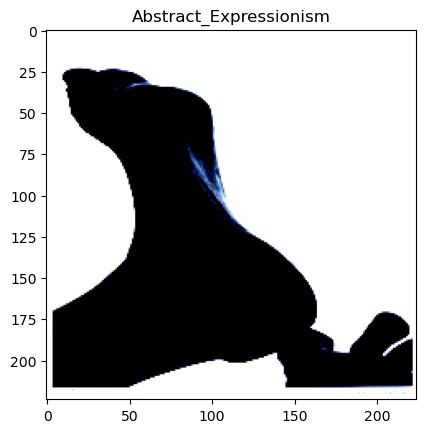

In [54]:
import matplotlib.pyplot as plt
# transpose the array to (28, 28) format expected by Matplotlib
array = np.transpose(dataset[0][0], (1, 2, 0))

# plot the image using Matplotlib
plt.title(dataset.classes[dataset[0][1]])
plt.imshow(array)
plt.show()


In [7]:
from collections import Counter

Counter([dataset.classes[t] for t in dataset.targets]).most_common(100)

[('Art_Nouveau_Modern', 1000),
 ('Baroque', 1000),
 ('Impressionism', 1000),
 ('Northern_Renaissance', 1000),
 ('Post_Impressionism', 1000),
 ('Realism', 1000),
 ('Romanticism', 1000),
 ('Symbolism', 1000),
 ('Abstract_Expressionism', 999),
 ('Expressionism', 999)]

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [10]:
train_size, test_size

(7998, 2000)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, input_size=None):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:
train_dataset

In [14]:
from tqdm import tqdm

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels, *extra in tqdm(test_loader, total=len(test_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            for e in extra:
                e = e.to(device)   
            outputs = model(inputs, *extra)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    return accuracy, f1, precision, recall


In [15]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    model.to(device)
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            dataloader = tqdm(dataloaders[phase], total=len(dataloaders[phase]))
            
            # Iterate over data.
            for inputs, labels, *extra in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                for e in extra:
                    e = e.to(device)    

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs, *extra)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "test":
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test Acc: {best_acc:4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history


In [16]:
# learn the input size

In [17]:
num_classes = len(dataset.classes)  # Number of classes in your dataset


In [18]:
# Create a sample input tensor with the size of (batch_size, channels, height, width)
sample_input = torch.randn(1, 3, 224, 224).to(device)
model = CNN(num_classes=num_classes, input_size=1)
# Perform a forward pass through the convolutional layers
sample_output = model.conv1(sample_input)
sample_output = model.pool(sample_output)
sample_output = model.conv2(sample_output)
sample_output = model.pool(sample_output)

# Calculate the size of the resulting tensor
input_size = sample_output.numel()
input_size

100352

In [19]:
dataset.classes

['Abstract_Expressionism',
 'Art_Nouveau_Modern',
 'Baroque',
 'Expressionism',
 'Impressionism',
 'Northern_Renaissance',
 'Post_Impressionism',
 'Realism',
 'Romanticism',
 'Symbolism']

In [20]:
# Step 1: Create an instance of the CNN model
cnn_model = CNN(num_classes=num_classes, input_size=input_size)

In [21]:
evaluate_model(cnn_model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:36<00:00,  1.14s/it]

Accuracy: 0.1015, F1-score: 0.0560, Precision: 0.1606, Recall: 0.1031



In [22]:
# Step 2: Create a dictionary containing both training and validation DataLoaders
dataloaders = {"train": train_loader, "test": test_loader}

# Step 3: Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Step 4: Train the model by calling the train_model function
num_epochs = 5
trained_cnn_model, test_acc_history = train_model(cnn_model, dataloaders, criterion, optimizer, device, num_epochs)


Epoch 1/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:03<00:00,  1.02it/s]


train Loss: 2.6537 Acc: 0.1715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:34<00:00,  1.09s/it]


test Loss: 2.1194 Acc: 0.2180

Epoch 2/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:02<00:00,  1.02it/s]


train Loss: 1.9916 Acc: 0.2824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.10s/it]


test Loss: 2.0504 Acc: 0.2545

Epoch 3/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:02<00:00,  1.02it/s]


train Loss: 1.5859 Acc: 0.4506


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.10s/it]


test Loss: 2.0602 Acc: 0.2825

Epoch 4/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:02<00:00,  1.02it/s]


train Loss: 0.8457 Acc: 0.7393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:34<00:00,  1.09s/it]


test Loss: 2.4143 Acc: 0.2740

Epoch 5/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:02<00:00,  1.02it/s]


train Loss: 0.2900 Acc: 0.9227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.10s/it]

test Loss: 3.1558 Acc: 0.2660

Training complete in 13m 8s
Best test Acc: 0.282500


In [23]:
evaluate_model(trained_cnn_model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:34<00:00,  1.09s/it]

Accuracy: 0.2825, F1-score: 0.2771, Precision: 0.3041, Recall: 0.2840



In [24]:
import torch
torch.save(trained_cnn_model.state_dict(), "../data/trained_cnn_model.pt")


# Text

In [25]:
# https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchtext
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [27]:

# Step 1: Load and preprocess the data
csv_path = '../data/disaster.csv'
df = pd.read_csv(csv_path)

# Tokenize the text column
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
tokenized = [tokenizer(text) for text in df['text']]

# Build the vocabulary
vocab = torchtext.vocab.build_vocab_from_iterator(tokenized)

# Encode the target column
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# Train-test split
train_data, test_data = train_test_split(df, test_size=0.2)

# Custom dataset
class TextDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        tokens = tokenizer(text)
        encoded_text = [vocab[token] for token in tokens]
        target = self.data.iloc[idx]['target']
        return torch.tensor(encoded_text), torch.tensor(target)

In [28]:
df['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [29]:

# Create the dataloaders
train_dataset = TextDataset(train_data, vocab)
test_dataset = TextDataset(test_data, vocab)

def pad_collate(batch):
    (sequences, targets) = zip(*batch)
    lengths = torch.tensor([len(sequence) for sequence in sequences])
    sequences = pad_sequence(sequences, batch_first=True)
    targets = torch.tensor(targets)
    return sequences, targets, lengths

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=pad_collate)

# Step 2: Create the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden.squeeze(0))
        return x

vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 128
num_classes = len(le.classes_)

lstm = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)


In [30]:
# TODO see if we can use the old train function

In [31]:
evaluate_model(lstm, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 482.58it/s]

Accuracy: 0.5161, F1-score: 0.5159, Precision: 0.5341, Recall: 0.5335



In [32]:
# Step 2: Create a dictionary containing both training and validation DataLoaders
dataloaders = {"train": train_loader, "test": test_loader}

# Step 4: Train the model by calling the train_model function
num_epochs = 5
trained_lstm_model, test_acc_history = train_model(lstm, dataloaders, criterion, optimizer, device, num_epochs)


Epoch 1/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [00:08<00:00, 93.31it/s]


train Loss: 0.6233 Acc: 0.6614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 498.81it/s]


test Loss: 0.5846 Acc: 0.7137

Epoch 2/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [00:08<00:00, 94.08it/s]


train Loss: 0.5182 Acc: 0.7552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 500.60it/s]


test Loss: 0.5597 Acc: 0.7393

Epoch 3/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [00:08<00:00, 92.26it/s]


train Loss: 0.3888 Acc: 0.8361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 493.23it/s]


test Loss: 0.6149 Acc: 0.7177

Epoch 4/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [00:08<00:00, 92.29it/s]


train Loss: 0.2878 Acc: 0.8836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 490.62it/s]


test Loss: 0.6766 Acc: 0.7157

Epoch 5/5
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [00:08<00:00, 91.93it/s]


train Loss: 0.1899 Acc: 0.9310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 492.07it/s]

test Loss: 0.9144 Acc: 0.6953

Training complete in 0m 43s
Best test Acc: 0.739330


In [33]:
evaluate_model(trained_lstm_model, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 494.26it/s]

Accuracy: 0.7393, F1-score: 0.7326, Precision: 0.7323, Recall: 0.7328

